<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.7/DC_GAN(%2Bvideo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DC GAN <br>
: CNN 구조로 generator와 discriminator를 구성한 GAN <br>
    -> 학습시키기 어렵다는 GAN의 단점을 보완하여 linear layer와 pooling layer 대신 convolution, transposed convolution 이용

- Fashin MNIST로 DC GAN 구현<br>
1) convolution, transposed convolution 사용 <br>
2) batch normalization 사용 <br>
3) 모든 layer에 ReLU/ Leaky ReLU 사용 <br>
- DC GAN의 이미지 생성 과정 animation으로 만들어 확인

In [4]:
import torch
import torch.nn as nn
import random
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [5]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

[1] Data processing

In [6]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,),(0.5,)),
])

# Download and load the training data
train = datasets.FashionMNIST(root='data',download=True,train=True,transform=transform)

trainloader = torch.utils.data.DataLoader(
    train,
    batch_size=100,
    shuffle=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



[2] Model

In [7]:
# Build Genarator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(25, 1024, 4, 1, 0, bias=False), 
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False), 
            nn.Tanh()) # sigmoid

    def forward(self, input):
        return self.main(input)
    
# Create the generator
netG = Generator().to(device)

In [8]:
# Weight Initialize

def weights_init(m):    
    layer_name = m.__class__.__name__
    #  Conv layer라면
    if layer_name.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    # Batch Normalization layer 라면
    elif layer_name.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)      
        # bias 는 0으로 취해준다
        nn.init.constant_(m.bias.data, 0)
    else:
       print('')
    # relu일 경우 아무것도 하지 않음
# Apply the weights_init function(weights to mean=0, stdev=0.2.)
netG.apply(weights_init)

# Print the model
print(netG)








Generator(
  (main): Sequential(
    (0): ConvTranspose2d(25, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
# Build Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (1,64,64)
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            
            # (128,32,32)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (256,16,16)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (512,8,8)
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (1024,4,4)
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # (100,1,1)
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator().to(device)
    
# Apply the weights_init function(weights to mean=0, stdev=0.2.)
netD.apply(weights_init)

# Print the model
print(netD)








Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# Define Loss function
loss_function = nn.BCELoss()

# Noise 더해줌
fixed_noise = torch.randn(64, 25, 1, 1).to(device)

# Discriminator 가 real 혹은 false 로 판단할 수 있게 scalar 값으로 labeling
real_label = 1
fake_label = 0

# Optimizer 지정
lr = 0.0001
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

[3] Training

In [13]:
# Training 

num_epochs = 5

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
  for i, data in enumerate(trainloader,0):
    # For each batch in the dataloader

        # 1. Real Image 로 Discriminator 훈련
   
        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        
        output = netD(real_cpu).view(-1) 
        output = output.type(torch.FloatTensor)
        label = label.type(torch.FloatTensor)
        errD_real = loss_function(output, label)

        errD_real.backward()
        D_x = output.mean().item() 

        # 2. Fake Image 로 Discriminator 훈련
       
        # Generator 에 들어갈 noise 생성
        noise = torch.randn(b_size, 25, 1, 1, device=device)
        
        # Generate 에서 fake image 생성 
        fake = netG(noise)

        label.fill_(fake_label)
        
        output = netD(fake.detach()).view(-1)
        errD_fake = loss_function(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        
        # Update Discriminator
        optimizerD.step()

        # (2) Update Generator
   
        netG.zero_grad()
        label.fill_(real_label)
        
        # Generator 가 만든 fake_image 를 Discriminator 에 넣어서 학습
        output = netD(fake).view(-1)
        
        errG = loss_function(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()

        if i % 600 == 0:
            print('[%d/%d]]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, 
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
      
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise.detach()).cpu()
            img_list.append(torchvision.utils.make_grid(fake, normalize=True))
            
        iters += 1

Starting Training Loop...
[1/5]]	Loss_D: 0.6319	Loss_G: 26.0286	D(x): 0.7792	D(G(z)): 0.0000 / 0.0000
[2/5]]	Loss_D: 0.3263	Loss_G: 4.1322	D(x): 0.9221	D(G(z)): 0.1883 / 0.0289
[3/5]]	Loss_D: 0.2385	Loss_G: 2.8171	D(x): 0.8933	D(G(z)): 0.0940 / 0.0849
[4/5]]	Loss_D: 0.5758	Loss_G: 2.4938	D(x): 0.6417	D(G(z)): 0.0232 / 0.1257
[5/5]]	Loss_D: 0.1304	Loss_G: 2.9946	D(x): 0.9315	D(G(z)): 0.0530 / 0.0710


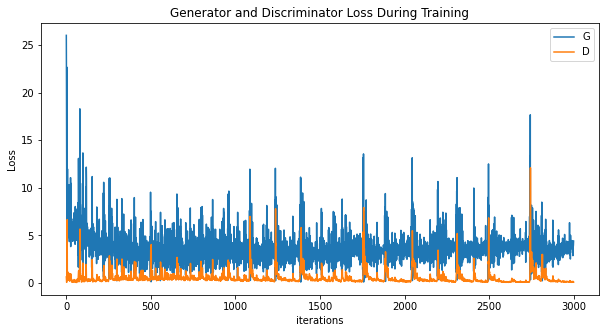

In [16]:
# loss plot
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[4] Test

In [17]:
sample_image = []
for batch_idx, (image, _) in enumerate(trainloader):
    sample_image.append(image[range(64)]) # 64개의 image
    break

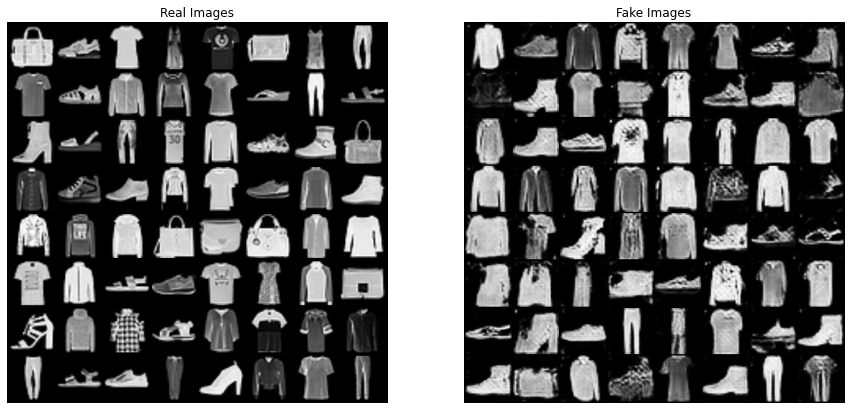

In [19]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(sample_image[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


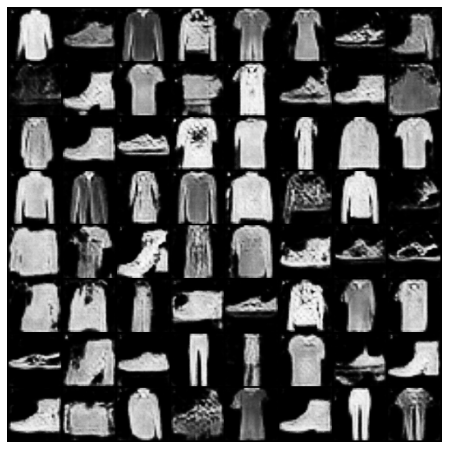

In [27]:
# video로 변해가는 과정 확인하기
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
img = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(img.to_jshtml())